In [1]:
import sys
# Add the parent directory to the system path
sys.path.insert(1, r"C:\Users\keena\Documents\University\python_scripts")

from Function_files.addresses import Init_Directories
import Function_files.data_functions as dat
from Function_files.filter_functions import smooth_data as gg
from Function_files.fitting_functions import fit_exp_decay, exp_decay
from Function_files.plotting_class import Plotter

plt = Plotter()
dirs = Init_Directories()

dirs.current = dirs.join(dirs.code, "Lifetime\T1\SP")
json = dirs.join(dirs.current, "configs", "08_SP.json")
info = dat.read_json(json)

In [2]:
# path to folders containing T1 data
path = dirs.join(info['file_loc'])
folder_list, file_list = dat.dir_interrogate(path, extensions=info['extensions'], exceptions=info['exceptions'])
phu_paths = dat.search_paths(folder_list, file_list, include=['.phu'])
phu_path_list = [[dirs.join(path, x) for x in phu_path] for phu_path in phu_paths]
dat_paths = dat.search_paths(folder_list, file_list, include=['.dat'])
dat_path_list = [dirs.join(path, x) for x in dat_paths]
ptu_paths = dat.search_paths(folder_list, file_list, include=['.ptu'])
ptu_path_list = [dirs.join(path, x) for x in ptu_paths]

In [3]:
# TODO add function to extract data from .dat files including the metadata (length, bin width etc.)
dat_data = [dat.read_file(x) for x in dat_path_list]
dat_ttd = [x[1][0] for x in dat_data]

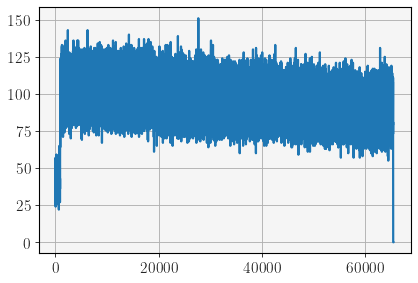

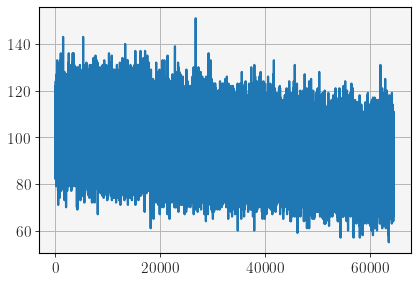

In [4]:
import matplotlib.pyplot as mp
import numpy as np
first = 950
last = 65433
fig, ax = mp.subplots()
ax.plot(dat_ttd[0][4:])
fig, ax = mp.subplots()
ax.plot(dat_ttd[0][first:last])

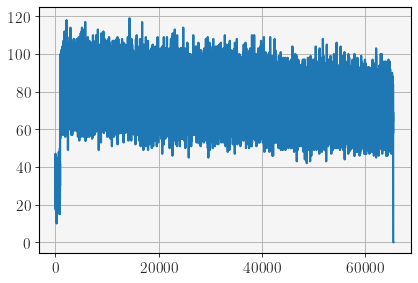

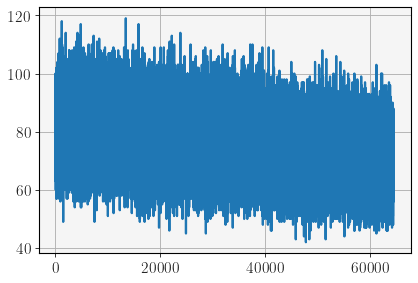

In [5]:
import matplotlib.pyplot as mp
import numpy as np
fig, ax = mp.subplots()
ax.plot(dat_ttd[1][4:])
fig, ax = mp.subplots()
ax.plot(dat_ttd[1][first:last])

In [6]:
from scipy.signal import fftconvolve
from Function_files.fitting_functions import gaussian
import numpy as np

def create_window(N, mode:str='square'):
    """
    Generates window for smoothing depending on user input

    Parameters
    ----------
    N : int
        Length of window
    mode : string
        Function to use for window > square, gaussian, blackman
    
    Returns
    -------
    out : array
        Normalised smoothing window of length N

    """
    if mode == 'square':
        window = np.ones(N)
    if mode == 'gaussian':
        window = gaussian(np.arange(N), 1, 0, N/2, (N-1)/5)
    if mode == 'blackman':
        window = blackman(N)

    return window / np.sum(window)

def blackman(N: int):
    """
    Generates blackman window

    Parameters
    ----------
    N : int
        Length of window
    
    Returns
    -------
    out : array
        Normalised Blackman window of length N

    """
    if not N % 2:
        N += 1

    n = np.arange(N)

    return 0.42 - 0.5 * np.cos(2*np.pi * n / (N-1)) + 0.08 * np.cos(4 * np.pi * n / (N-1))


def smooth_data(data,
                N:int=100,
                mode:str='square',
                pad_mode:str='edge'
                ):
    """
    Filter a given array of data using chosen type of smoothing function.
    Uses fftconvolve for speed and mirrors data to remove edge effects.
    
    Parameters
    ----------
    data : array
        Input array of data to be smoothed    
    N : int
        Length of filter
    mode : str
        Smoothing function to use > square, gaussian, blackman
    pad_mode : str
        Type of padding to use - see numpy pad for details
    Returns
    -------
    out : array
        Filtered data

    """
    # create a boxcar window and then create a list of smoothed data
    avg_window = create_window(N, mode)
    # pad data to avoid edge effects
    N_pad = len(data)//2
    padded = np.pad(data, N_pad, mode=pad_mode)
    return fftconvolve(avg_window, padded)[N_pad+N//2:-N_pad-N//2]


In [7]:
test_smooth = smooth_data(dat_ttd[0][first:last], pad_mode='edge')

In [8]:
len(dat_ttd[0][first:last]), len(test_smooth)

(64483, 64482)

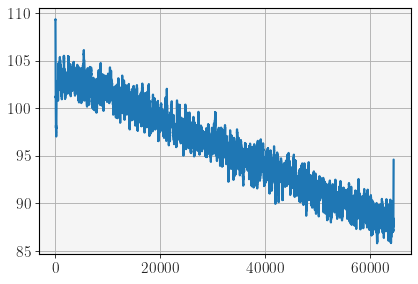

In [9]:
fig, ax = mp.subplots()
ax.plot(test_smooth)

In [10]:
stitched = dat_ttd[0][first:last]
[stitched.extend(dat_ttd[x][first:last]) for x in range(1, len(dat_ttd))]
smooth_sets = [smooth_data(x[first:last], 1000) for x in dat_ttd]
dt = 512E-12
time = [dt*1E6*x for x in range(len(stitched))]

[Text(0.5, 1.0, 'PrYSO Bulk Fluorescence (SP)')]

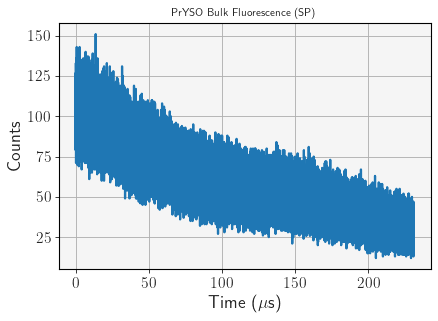

In [11]:
# TODO add functionality to autodetect edges between stitches and smooth together

fig, ax = mp.subplots()
ax.plot(time, stitched)
ax.set(xlabel=('Time ($\\mu$s)'),  ylabel=('Counts'))
ax.set(title=('PrYSO Bulk Fluorescence (SP)'))

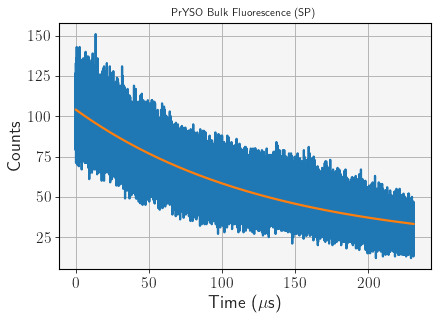

In [12]:
try_fit = fit_exp_decay(time, stitched)
fig, ax = mp.subplots()
ax.plot(time, stitched)
ax.set(xlabel=('Time ($\\mu$s)'),  ylabel=('Counts'))
ax.set(title=('PrYSO Bulk Fluorescence (SP)'))
ax.plot(time, exp_decay(np.array(time), *try_fit[0]))